 # IEEE-CIS Fraud Detection

Vesta Corporation provided the dataset for this model. Vesta Corporation is the forerunner in guaranteed e-commerce payment solutions. Founded in 1995, Vesta pioneered the process of fully guaranteed card-not-present (CNP) payment transactions for the telecommunications industry. Since then, Vesta has firmly expanded data science and machine learning capabilities across the globe and solidified its position as the leader in guaranteed ecommerce payments. Today, Vesta guarantees more than $18B in transactions annually. 

Problem: Binary classification with a heavy dataset imbalance

## Objective: Detect fraud in Transactions

### Data:  
  
``isFraud`` is the binary that denotes whether a transaction is fraud or not and this is the dependent variable to be modeled for  

Data is broken into two files ***identity*** and ***transaction***, these can be join by the ``TransactioID``  
  
***Identity Categorical Features***
* DeviceType
* DeviceInfo
* id_12-id_38
  
***Transaction Categorical Features***
* Product CD
* emaildomain
* card1-card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1-M9

The ``TransactionDT`` feature is a timedelta from a given reference datetime (not an actual timestamp).


## Import Required Modules

In [34]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report
from catboost.utils import get_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')


# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

In [14]:
# Functions

# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


## Load the Dataset

In [93]:
FOLDER_PATH = 'data'
train_identity = pd.read_csv(f'{FOLDER_PATH}/train_identity.csv')
train_transaction = pd.read_csv(f'{FOLDER_PATH}/train_transaction.csv')
test_identity = pd.read_csv(f'{FOLDER_PATH}/test_identity.csv')
test_transaction = pd.read_csv(f'{FOLDER_PATH}/test_transaction.csv')

In [94]:
# merge the testing and training data
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [95]:
print(f'Transaction df shape: {train_transaction.shape}')
train_transaction.head()

Transaction df shape: (590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
print(f'Identity df shape: {train_identity.shape}')
train_identity.head()

Identity df shape: (144233, 41)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [97]:
del train_identity, train_transaction, test_identity, test_transaction

## Exploratory Data Analysis

Click [here](https://github.com/JoshSpangler96/IEEE-CIS-Fraud-Detection/blob/main/IEEE_Fraud_Detection_EDA.ipynb) to view the EDA I performed for this dataset \
\
Key takeaways from EDA: 
* Highly imbalanced dataset with 3.5% fraud
* Train data and test data are seperated by time. Need time based split for validation set
* Ff the 415 features in the V, C, D, M, and ID categories there are 136 uncorrelated useful features
* Highest precentage of Fraud happens early morning

In [98]:
test.columns = test.columns.str.replace('[-]', '_')

In [99]:
# Keep only the useful columns from the EDA
features_to_use = [
    'TransactionID', 'TransactionDT', 'TransactionAmt', 
    'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'DeviceType', 
    'DeviceInfo', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 
    'V147', 'V142', 'V1', 'V174', 'V109', 'V201', 'V238', 'V271', 'V78', 
    'V160', 'V65', 'V339', 'V27', 'V138', 'V320', 'V6', 'V223', 'V114', 
    'V118', 'V173', 'V80', 'V107', 'V258', 'V44', 'V198', 'V252', 'V220', 
    'V309', 'V209', 'V67', 'V124', 'V260', 'V155', 'V176', 'V55', 'V36', 
    'V325', 'V127', 'V175', 'V82', 'V20', 'V329', 'V111', 'V139', 'V210', 
    'V30', 'V86', 'V3', 'V37', 'V13', 'V207', 'V286', 'V47', 'V162', 'V8', 
    'V62', 'V234', 'V56', 'V240', 'V23', 'V4', 'V115', 'V166', 'V121', 'V76', 
    'V259', 'V312', 'V120', 'V169', 'V305', 'V291', 'V185', 'V26', 'V241', 
    'V250', 'V108', 'V261', 'V54', 'D5', 'D14', 'D1', 'D9', 'D13', 'D8', 
    'D15', 'D10', 'C1', 'C5', 'C3', 'M5', 'M7', 'M4', 'M2', 'M9', 'M6', 
    'M1', 'M3', 'M8', 'id_08', 'id_09', 'id_28', 'id_07', 'id_37', 'id_01', 
    'id_27', 'id_25', 'id_21', 'id_12', 'id_38', 'id_35', 'id_30', 'id_04', 
    'id_05', 'id_29', 'id_36', 'id_34', 'id_11', 'id_26', 'id_13', 'id_24', 
    'id_23', 'id_20', 'id_17', 'id_14', 'id_31', 'id_32', 'id_03', 'id_10', 
    'id_18', 'id_02', 'id_06', 'id_16', 'id_15', 'id_19', 'id_33', 'id_22']

#reduce both test and train
print(f'Datasets have {len(train.columns)} features before reduction')
train_features = features_to_use + ['isFraud']
train = train[train_features]
test = test[features_to_use]
print(f'Datasets have {len(train.columns)} features after reduction')

Datasets have 434 features before reduction
Datasets have 155 features after reduction


## Feature Engineering

In [100]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")

# create a cents feature
datasets = [train, test]
for data in datasets:
    data['cents'] = (data['TransactionAmt'] - np.floor(data['TransactionAmt'])).astype('float32')
    data['log_TransactionAmt'] = np.log(data['TransactionAmt'])
    data[['P_email_1', 'P_email_2', 'P_email_3']] = data['P_emaildomain'].str.split('.', expand=True)
    data.drop('P_emaildomain', axis=1, inplace=True)
    data[['R_email_1', 'R_email_2', 'R_email_3']] = data['R_emaildomain'].str.split('.', expand=True)
    data.drop('R_emaildomain', axis=1, inplace=True)
    data['Date'] = data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
    data['Weekdays'] = data['Date'].dt.dayofweek
    data['Hours'] = data['Date'].dt.hour
    data['Days'] = data['Date'].dt.day
    
print(f'Datasets have {len(train.columns)} features after feature engineering')

Datasets have 165 features after feature engineering


## Prepare for Modeling

***Dropping Bad Columns***

In [108]:
# row_count = train.shape[0]
# row_count

In [104]:
# # get a list of columns with over 90% null values
# nan_col = [col for col in train.columns if (train[col].isnull().sum() / row_count) > 0.9]
# nan_col_test = [col for col in test.columns if (test[col].isnull().sum() / row_count) > 0.9]

# # get a list of columns that are dominated by one value
# vast_majority_col = [col for col in train.columns \
#                            if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
# vast_majority_col_test = [col for col in test.columns \
#                            if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [49]:
# drop_cols = nan_col + nan_col_test + vast_majority_col + vast_majority_col_test
# drop_cols.remove('isFraud')

In [109]:
# print(f'Dropping {len(train_drop)} columns from the dataframe')

In [51]:
# train.drop(train_drop, axis=1, inplace=True)
# test.drop(test_drop, axis=1, inplace=True)

***Categorical Feature Encoding***

In [110]:
train_cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', \
            'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', \
            'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', \
            'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', \
            'P_emaildomain', 'R_emaildomain', 'card1', 'card2', 'card3', 'card4', 'card5',\
            'card6', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', \
           ]

In [132]:
d_type = pd.DataFrame(train.dtypes)
d_type.rename({0: 'dtype'}, axis=1,  inplace=True)
d_type.reset_index(inplace=True)
cat_col = dtypes[]

,index,dtype
0,TransactionID,int64
1,TransactionDT,int64
2,TransactionAmt,float64
3,ProductCD,object
4,card1,int64
...,...,...
160,R_email_3,object
161,Date,datetime64[ns]
162,Weekdays,int64
163,Hours,int64


In [53]:
for i in range(len(train_cat_cols)):
    if train_cat_cols[i] in train.columns:
        le = LabelEncoder()
        le.fit(list(train[train_cat_cols[i]].astype(str).values) + list(test[test_cat_cols[i]].astype(str).values))
        train[train_cat_cols[i]] = le.transform(list(train[train_cat_cols[i]].astype(str).values))
        test[test_cat_cols[i]] = le.transform(list(test[test_cat_cols[i]].astype(str).values))   

In [54]:
# set up X train and y train
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID', 'Date'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']

***Clean Missing Values***

In [55]:
X.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [56]:
import gc
gc.collect()

45

***Reduce Memory Usage***

In [ ]:
# reduce the memory usage
train = reduce_mem_usage2(train)

### Modeling

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [68]:
from sklearn import metrics
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

XGBOOST

In [59]:
xgb_clf = xgb.XGBClassifier(
    learning_rate=0.03,
    n_estimators=1000,
    max_depth = 5,
    min_child_weight=1,
    subsample=0.8,
    objective='reg:logistic',
    eval_metric='auc',
)
xgb_clf.fit(X_train, y_train)

C:\Users\JSPANGLER\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

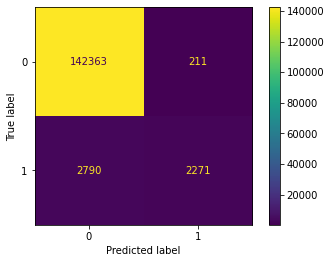

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142574
           1       0.91      0.45      0.60      5061

    accuracy                           0.98    147635
   macro avg       0.95      0.72      0.80    147635
weighted avg       0.98      0.98      0.98    147635



In [71]:
y_pred = xgb_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cb_clf.classes_)
disp.plot()
plt.show()
target_names = y.unique().tolist()
for i in range(len(target_names)):
    target_names[i] = str(target_names[i])
print(classification_report(y_test, y_pred, target_names=target_names))

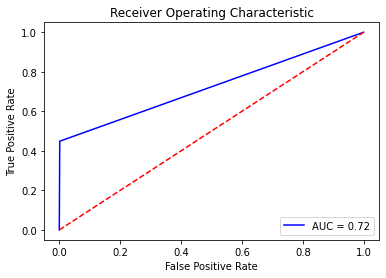

In [72]:
buildROC(y_test, y_pred)

Terrible Recall on this model. A Dummy variable that gueses no fraud every time would do just as well or even better

CAT BOOST

In [61]:
cb_params={
    'learning_rate':0.03,
    'iterations': 50,
    'depth':13,
    'verbose':10
}

cb_clf = CatBoostClassifier(**cb_params)
cb_clf.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)], 
)

0:	learn: 0.6422371	test: 0.6423315	test1: 0.6423109	best: 0.6423109 (0)	total: 5.79s	remaining: 4m 43s
10:	learn: 0.3244578	test: 0.3244679	test1: 0.3240805	best: 0.3240805 (10)	total: 1m 1s	remaining: 3m 38s
20:	learn: 0.1982313	test: 0.1983119	test1: 0.1977608	best: 0.1977608 (20)	total: 1m 53s	remaining: 2m 37s
30:	learn: 0.1446114	test: 0.1447015	test1: 0.1443361	best: 0.1443361 (30)	total: 2m 46s	remaining: 1m 42s
40:	learn: 0.1204095	test: 0.1204868	test1: 0.1203903	best: 0.1203903 (40)	total: 3m 39s	remaining: 48.2s
49:	learn: 0.1087083	test: 0.1087739	test1: 0.1090030	best: 0.1090030 (49)	total: 4m 28s	remaining: 0us

bestTest = 0.109002967
bestIteration = 49



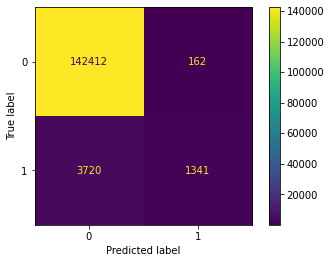

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    142574
           1       0.89      0.26      0.41      5061

    accuracy                           0.97    147635
   macro avg       0.93      0.63      0.70    147635
weighted avg       0.97      0.97      0.97    147635



In [73]:
y_pred = cb_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cb_clf.classes_)
disp.plot()
plt.show()
target_names = y.unique().tolist()
for i in range(len(target_names)):
    target_names[i] = str(target_names[i])
print(classification_report(y_test, y_pred, target_names=target_names))

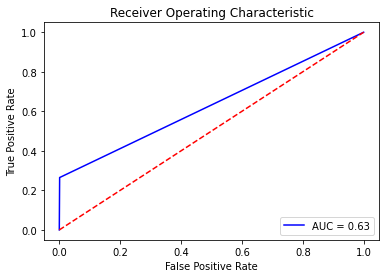

In [74]:
buildROC(y_test, y_pred)

Terrible Recall on this model. A Dummy variable that gueses no fraud every time would do just as well or even better

LGBM

In [76]:
parameters = {
    'num_leaves': 256,
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'max_depth': 13,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.03,
    'verbose': 0,
    'n_estimators':5000
}

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

model = lgb.LGBMClassifier(**parameters, n_jobs = -1)
model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    eval_metric='auc',
    verbose=False
)

C:\Users\JSPANGLER\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testi

LGBMClassifier(bagging_fraction=0.5, bagging_freq=20, boosting='gbdt',
               feature_fraction=0.5, is_unbalance='true', learning_rate=0.03,
               max_depth=13, metric='auc', n_estimators=5000, num_leaves=256,
               objective='binary', verbose=0)

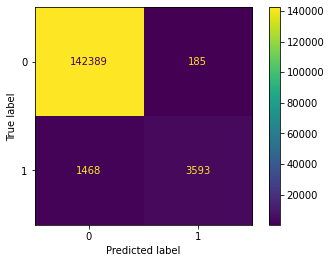

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    142574
           1       0.95      0.71      0.81      5061

    accuracy                           0.99    147635
   macro avg       0.97      0.85      0.90    147635
weighted avg       0.99      0.99      0.99    147635



In [77]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cb_clf.classes_)
disp.plot()
plt.show()
target_names = y.unique().tolist()
for i in range(len(target_names)):
    target_names[i] = str(target_names[i])
print(classification_report(y_test, y_pred, target_names=target_names))

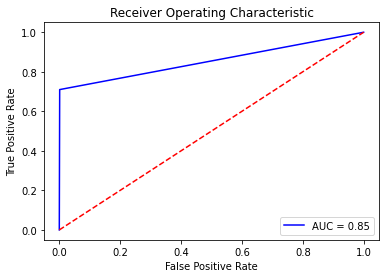

In [78]:
buildROC(y_test, y_pred)